#### Importing necessary libraries

In [ ]:
# Installing necessary packages
%pip install swig xvfb

# Install gfootball
%pip install gfootball

# install gfootball compatible setup tools
%pip install setuptools==59.5.0

# Install stable-baselines3
%pip install stable-baselines3==1.3.0


Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement xvfb (from versions: none)
ERROR: No matching distribution found for xvfb


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


#### Setting up the Environment

In [1]:
## Training Example

# Import necessary libraries and modules
import os
import gym  # Using gym instead of gymnasium for compatibility with gfootball
import stable_baselines3
from stable_baselines3 import PPO
from stable_baselines3.common.monitor import Monitor, load_results
from stable_baselines3.common.callbacks import BaseCallback, CallbackList, EvalCallback, CheckpointCallback
from stable_baselines3.common.results_plotter import ts2xy
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor

import torch.nn as nn
import torch
import numpy as np
import matplotlib.pyplot as plt

import cv2

# Print the versions of gym and stable_baselines3 to confirm compatibility
print(f"gym.__version__ = {gym.__version__}")
print(f"stable_baselines3.__version__ = {stable_baselines3.__version__}")

# Set up directories for logging, model checkpoints, videos, and TensorBoard
log_dir = "gfootball_logs/logs"
models_dir = "gfootball_logs/models"
videos_dir = "gfootball_logs/videos"
tensorboard_log_dir = "gfootball_logs/tensorboard"
os.makedirs(log_dir, exist_ok=True)             # Create log directory if it doesn't exist
os.makedirs(models_dir, exist_ok=True)          # Create model directory if it doesn't exist
os.makedirs(videos_dir, exist_ok=True)          # Create video directory if it doesn't exist
os.makedirs(tensorboard_log_dir, exist_ok=True) # Create TensorBoard directory if it doesn't exist

# Custom environment wrapper to aggregate rewards and done flags for all agents
class SingleAgentRewardWrapper(gym.Wrapper):
    def __init__(self, env):
        super(SingleAgentRewardWrapper, self).__init__(env)
        self.observation_space = env.observation_space  # Observation space from the original environment
        self.action_space = env.action_space            # Action space from the original environment

    def step(self, action):
        obs, reward, done, info = self.env.step(action)  # Take a step in the environment
        # Aggregate per-agent rewards by summing them up
        reward = np.sum(reward)  # Sum over all agents to get a single reward
        # Aggregate per-agent done flags to mark episode as done if any agent is done
        done = np.any(done)
        return obs, reward, done, info

    def reset(self):
        return self.env.reset()  # Reset the environment and return the initial observation

# Function to create the gfootball environment
def make_env(env_id):
    import gfootball.env as football_env
    def _init():
        # Create a 5 vs 5 gfootball environment
        env = football_env.create_environment(
            env_name='5_vs_5',                       # Use a 5 vs 5 setup
            representation='extracted',              # Use 'extracted' representation for observations
            render=False,                            # Disable rendering (we'll use render later if needed)
            rewards='scoring, checkpoints',          # Reward options (scoring and checkpoint rewards)
            number_of_left_players_agent_controls=5, # Set number of agent-controlled players
            number_of_right_players_agent_controls=0 # Set number of CPU-controlled players
        )
        env = SingleAgentRewardWrapper(env)           # Apply the custom reward wrapper
        # Specify the monitor filename for logging each environment's data
        monitor_filename = os.path.join(log_dir, f"monitor_{env_id}.csv")
        env = Monitor(env, filename=monitor_filename) # Wrap with Monitor for logging
        return env
    return _init

# Create a vectorized environment with multiple parallel instances
num_envs = 8  # Set the number of parallel environments based on system capabilities
envs = [make_env(i) for i in range(num_envs)]  # Initialize each environment instance
env = DummyVecEnv(envs)  # Vectorize the environments for parallel execution

# After creating the environment and before initializing the model, print environment details
print(f"Observation space shape: {env.observation_space.shape}")  # Display the shape of the observation space
print(f"Action space: {env.action_space}")                        # Display the action space type and size


gym.__version__ = 0.17.3
stable_baselines3.__version__ = 1.3.0
Observation space shape: (5, 72, 96, 4)
Action space: MultiDiscrete([19 19 19 19 19])


#### Create a Custom CNN Feature Extractor

In [2]:
# Define Residual Block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1):
        super(ResidualBlock, self).__init__()
        # First convolutional layer of the residual block
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)      # Batch normalization after the first convolution
        self.relu = nn.LeakyReLU(0.1)                # LeakyReLU activation
        # Second convolutional layer of the residual block
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size, stride, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)      # Batch normalization after the second convolution
        
        # Define shortcut connection
        self.shortcut = nn.Sequential()  # Identity if in_channels == out_channels
        if in_channels != out_channels:
            # If input and output channels differ, use a 1x1 convolution to match dimensions
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )
        
    def forward(self, x):
        # Forward pass through residual block
        out = self.relu(self.bn1(self.conv1(x)))  # Apply first conv, batch norm, and activation
        out = self.bn2(self.conv2(out))           # Apply second conv and batch norm
        out += self.shortcut(x)                   # Add the shortcut connection
        out = self.relu(out)                      # Final activation
        return out

# Enhanced CNN Feature Extractor
class CustomCNN(BaseFeaturesExtractor):
    """
    Enhanced CNN to process the 'extracted' observations from GFootball.
    Incorporates residual connections, batch normalization, dropout, and a deeper architecture.
    """
    def __init__(self, observation_space: gym.spaces.Box, features_dim: int = 512):
        super(CustomCNN, self).__init__(observation_space, features_dim)
        
        # Get observation space dimensions
        num_agents, height, width, channels_per_agent = observation_space.shape
        self.num_agents = num_agents
        self.height = height
        self.width = width
        self.channels_per_agent = channels_per_agent
        
        # Total input channels, combining channels from each agent
        n_input_channels = self.num_agents * self.channels_per_agent
    
        # Define the CNN architecture with residual blocks
        self.cnn = nn.Sequential(
            nn.Conv2d(n_input_channels, 64, kernel_size=8, stride=4),  # Initial convolutional layer
            nn.BatchNorm2d(64),              # Batch normalization to stabilize learning
            nn.LeakyReLU(0.1),               # Activation function
            nn.MaxPool2d(kernel_size=2, stride=2),  # Max pooling to downsample the spatial dimensions
            
            ResidualBlock(64, 128, kernel_size=3, stride=1),  # First residual block
            ResidualBlock(128, 256, kernel_size=3, stride=1), # Second residual block
            ResidualBlock(256, 256, kernel_size=3, stride=1), # Third residual block
            
            nn.AdaptiveAvgPool2d((1, 1)),    # Adaptive average pooling to flatten spatial dimensions
            nn.Flatten(),                    # Flatten the tensor to prepare for linear layers
        )
        
        # Compute the size of the output tensor after the CNN layers
        with torch.no_grad():
            # Create a dummy input with the correct shape to determine the flattened size
            sample_input = torch.zeros(1, n_input_channels, height, width)
            n_flatten = self.cnn(sample_input).shape[1]
        
        # Define the linear layers with dropout for regularization
        self.linear = nn.Sequential(
            nn.Linear(n_flatten, 1024),      # Fully connected layer to reduce dimensionality
            nn.LeakyReLU(0.1),               # Activation function
            nn.Dropout(p=0.5),               # Dropout for regularization to prevent overfitting
            nn.Linear(1024, features_dim),   # Final fully connected layer outputting feature dimensions
            nn.ReLU(),                       # Final activation
        )
        
        # Set the features dimension attribute
        self._features_dim = features_dim

    def forward(self, observations: torch.Tensor) -> torch.Tensor:
        # observations shape: (batch_size, num_agents, height, width, channels_per_agent)
        batch_size = observations.shape[0]
        # Reshape observations to (batch_size, num_agents * channels_per_agent, height, width)
        observations = observations.view(
            batch_size,
            self.num_agents * self.channels_per_agent,
            self.height,
            self.width
        )
        # Forward pass through CNN layers
        features = self.cnn(observations)
        # Forward pass through linear layers to get final feature vector
        return self.linear(features)


#### Generate Feature Extractor Architecture

In [10]:
from torchsummary import summary


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Assuming observation_space.shape is (5, 72, 96, 4) for a 5-agent scenario
observation_space = gym.spaces.Box(low=0, high=255, shape=(5, 72, 96, 4), dtype=np.uint8)

# Instantiate the CustomCNN feature extractor
model = CustomCNN(observation_space, features_dim=512).to(device)

# Use torchsummary to summarize the model
summary(model, input_size=(20, 72, 96))  # Total input channels: 5 agents * 4 channels per agent


Using device: cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 17, 23]          81,984
       BatchNorm2d-2           [-1, 64, 17, 23]             128
         LeakyReLU-3           [-1, 64, 17, 23]               0
         MaxPool2d-4            [-1, 64, 8, 11]               0
            Conv2d-5           [-1, 128, 8, 11]          73,856
       BatchNorm2d-6           [-1, 128, 8, 11]             256
         LeakyReLU-7           [-1, 128, 8, 11]               0
            Conv2d-8           [-1, 128, 8, 11]         147,584
       BatchNorm2d-9           [-1, 128, 8, 11]             256
           Conv2d-10           [-1, 128, 8, 11]           8,320
      BatchNorm2d-11           [-1, 128, 8, 11]             256
        LeakyReLU-12           [-1, 128, 8, 11]               0
    ResidualBlock-13           [-1, 128, 8, 11]               0
           Conv2d-14

#### Generate Feature Extractor Architecture image

In [35]:
from torchviz import make_dot

# Create a dummy input tensor matching the expected input size
# Shape: (batch_size, num_agents, height, width, channels_per_agent) = (1, 5, 72, 96, 4)
dummy_input = torch.zeros(1, 5, 72, 96, 4).to(device)


# Pass the dummy input through the model to generate the computational graph
output = model(dummy_input.view(1,20,72,96))

# Use torchviz to visualize the model's computational graph
graph = make_dot(output, params=dict(model.named_parameters()))
graph.render("CustomCNN", format="png")  # Saves the graph as "CustomCNN.png"



'CustomCNN.png'

#### Model Parameters

In [3]:
# Initialize the PPO agent with specified parameters
model = PPO(
    policy='CnnPolicy',              # Use a CNN policy
    env=env,                         # The environment in which the agent will train
    verbose=2,                       # Set verbosity level for more detailed logs
    clip_range=0.1576,               # Clip range for PPO to prevent large updates
    ent_coef=0.0005437,              # Entropy coefficient for regularizing exploration
    learning_rate=0.0003949,         # Learning rate for updating the model
    n_epochs=10,                     # Number of epochs per update
    n_steps=1024,                    # Number of steps per environment rollout
    vf_coef=0.9939,                  # Value function coefficient for the loss function
    gae_lambda=0.95,                 # GAE (Generalized Advantage Estimation) lambda
    batch_size=512,                  # Batch size for training
    gamma=0.9759,                    # Discount factor for rewards
    tensorboard_log=tensorboard_log_dir,  # Enable TensorBoard logging for visualizing metrics
    policy_kwargs={"features_extractor_class": CustomCNN}  # Custom CNN for feature extraction
)


Using cuda device


#### Define a Save Function

In [6]:
# Define a callback class for saving models at regular intervals during training
class SaveOnIntervalCallback(BaseCallback):
    def __init__(self, save_interval: int, save_path: str, verbose=1):
        # Initialize the callback with save interval, save path, and verbosity level
        super().__init__(verbose)  # Call the parent constructor with verbosity setting
        self.save_interval = save_interval  # Number of timesteps between saves
        self.save_path = save_path  # Directory path where models will be saved

    def _on_step(self) -> bool:
        # Check if the current number of timesteps is a multiple of the save interval
        if self.num_timesteps % self.save_interval == 0:
            # Construct the filename for saving the model, including the current timestep count
            save_file = os.path.join(self.save_path, f'model_{self.num_timesteps}')
            self.model.save(save_file)  # Save the model to the specified file path
            if self.verbose > 0:  # If verbosity is enabled, print a message indicating that the model was saved
                print(f'Saving model to {save_file}.zip')
        # Return True to continue the training loop
        return True


#### Training and Saving the Model

In [6]:

# Define the interval at which models are saved during training
total_timesteps = 25000000  # Total training timesteps
save_interval = total_timesteps // 10  # Save every 500,000 timesteps

# Create the save callback
save_callback = SaveOnIntervalCallback(save_interval=save_interval, save_path=models_dir, verbose=1)

# Train the PPO model
model.learn(total_timesteps=total_timesteps, callback=save_callback, tb_log_name='PPO_GFootball')

# Save the final model
final_model_path = os.path.join(models_dir, 'model_final')
model.save(final_model_path)


Logging to gfootball_logs/tensorboard\PPO_GFootball_1
-----------------------------
| time/              |      |
|    fps             | 148  |
|    iterations      | 1    |
|    time_elapsed    | 55   |
|    total_timesteps | 8192 |
-----------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 117          |
|    iterations           | 2            |
|    time_elapsed         | 139          |
|    total_timesteps      | 16384        |
| train/                  |              |
|    approx_kl            | 0.0074617825 |
|    clip_fraction        | 0.12         |
|    clip_range           | 0.158        |
|    entropy_loss         | -14.7        |
|    explained_variance   | -0.052316546 |
|    learning_rate        | 0.000395     |
|    loss                 | -0.0226      |
|    n_updates            | 10           |
|    policy_gradient_loss | -0.0144      |
|    value_loss           | 0.0612       |
-----

#### Plotting the results

c:\Users\Leon-PC\anaconda3\envs\gfoot_env2\lib\site-packages\stable_baselines3\common\monitor.py:234: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data_frame = pandas.concat(data_frames)


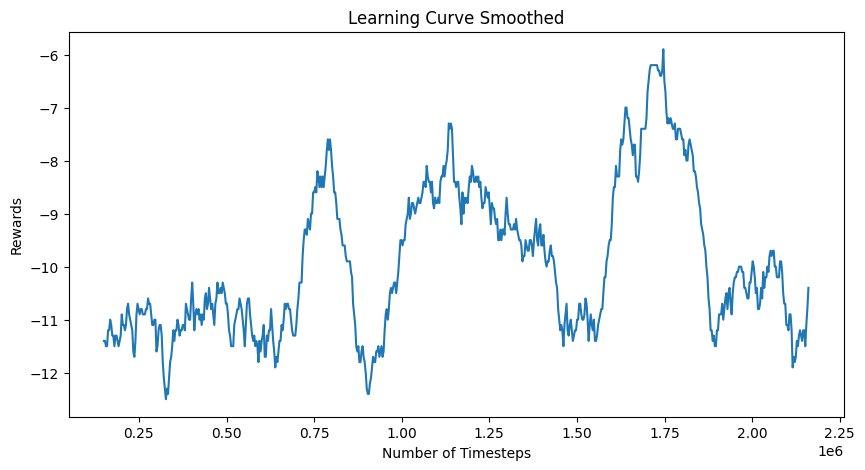

In [ ]:
# Function for plotting the learning curve
def plot_results(log_folder, title="Learning Curve"):
    # Load and process the training log data
    x, y = ts2xy(load_results(log_folder), "timesteps")  # Extract timesteps and rewards
    y = np.convolve(y, np.ones((50,))/50, mode='valid')  # Smooth the rewards using a moving average
    x = x[len(x) - len(y):]  # Align x-axis to match smoothed y-axis length
    
    # Plotting the learning curve
    plt.figure(figsize=(10, 5))  # Set the figure size
    plt.plot(x, y)               # Plot the smoothed rewards against timesteps
    plt.xlabel("Number of Timesteps")  # Label for x-axis
    plt.ylabel("Rewards")              # Label for y-axis
    plt.title(title + " Smoothed")     # Title for the plot
    plt.show()                         # Display the plot

# Call the plotting function after training
plot_results(log_dir)  # 'log_dir' contains the path to the log files from training

#### Model Finetuning

In [8]:
# Finetuning the model (not much improvement)

# Load the pre-trained model
final_model_path = os.path.join(models_dir, 'model_final.zip')  # Path to the final saved model
model = PPO.load(final_model_path, env=env)                    # Load the model and set the environment

# Set new hyperparameters for finetuning
model.ent_coef = 1.6409921004681657e-05    # Update entropy coefficient to adjust exploration-exploitation balance
model.vf_coef = 0.675860207646746          # Update value function coefficient for loss function
model.gamma = 0.9063120098737588           # Update discount factor for rewards
model.clip_range = lambda _: 0.3724687350484571  # Update clip range using a lambda function

# Define the number of additional timesteps for further training
additional_timesteps = 50000  # Number of additional timesteps

# Continue training the model with the updated hyperparameters
model.learn(total_timesteps=additional_timesteps, tb_log_name='PPO_GFootball_Improved')  # Log to TensorBoard

# Save the improved model
improved_model_path = os.path.join(models_dir, 'model_final_FT')  # Path for saving the fine-tuned model
model.save(improved_model_path, exclude=['env'])                  # Save model, excluding the environment data


c:\Users\Leon-PC\anaconda3\envs\gfoot_env2\lib\site-packages\stable_baselines3\common\save_util.py:435: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  th_object = th.load(fil

Logging to gfootball_logs/tensorboard\PPO_GFootball_Improved_8
-----------------------------
| time/              |      |
|    fps             | 149  |
|    iterations      | 1    |
|    time_elapsed    | 54   |
|    total_timesteps | 8192 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 2           |
|    time_elapsed         | 152         |
|    total_timesteps      | 16384       |
| train/                  |             |
|    approx_kl            | 0.12863997  |
|    clip_fraction        | 0.222       |
|    clip_range           | 0.372       |
|    entropy_loss         | -12.1       |
|    explained_variance   | 0.051275194 |
|    learning_rate        | 0.000395    |
|    loss                 | 0.0201      |
|    n_updates            | 30530       |
|    policy_gradient_loss | -0.0258     |
|    value_loss           | 0.0647      |
-------------

#### Video Recording

In [4]:
# Custom VideoRecordingWrapper Class

class VideoRecordingWrapper(gym.Wrapper):
    def __init__(self, env, video_folder, video_name, video_length=3000, fps=30):
        super(VideoRecordingWrapper, self).__init__(env)
        self.video_folder = video_folder      # Directory to save the video
        self.video_name = video_name          # Name of the video file
        self.video_length = video_length      # Maximum length of the video in frames
        self.frame_count = 0                  # Counter to keep track of frames written
        self.fps = fps                        # Frames per second for the video
        self.video_writer = None              # Video writer object (initially None)
        self.frame_size = None                # Size of each frame (width, height)
        os.makedirs(self.video_folder, exist_ok=True)  # Ensure the folder exists

    def reset(self):
        obs = self.env.reset()                # Reset the environment and get the initial observation
        frame = self.env.render(mode='rgb_array')  # Render the initial frame in RGB format
        if self.frame_size is None:
            # Set the frame size based on the environment's render output
            self.frame_size = (frame.shape[1], frame.shape[0])  # (width, height)
            video_path = os.path.join(self.video_folder, self.video_name)  # Full path for saving video
            # Initialize the video writer with the specified codec and frame size
            fourcc = cv2.VideoWriter_fourcc(*'H264')  # You can use 'XVID' or 'avc1'
            self.video_writer = cv2.VideoWriter(video_path, fourcc, self.fps, self.frame_size)
        # Convert the frame from RGB to BGR (OpenCV uses BGR) and write to video
        frame_bgr = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
        self.video_writer.write(frame_bgr)
        self.frame_count = 1                  # Initialize the frame count
        return obs

    def step(self, action):
        obs, reward, done, info = self.env.step(action)  # Step through the environment
        if self.frame_count < self.video_length:  # Check if video length limit is reached
            frame = self.env.render(mode='rgb_array')  # Render the frame
            frame_bgr = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)  # Convert to BGR for OpenCV
            self.video_writer.write(frame_bgr)  # Write the frame to video
            self.frame_count += 1               # Increment frame count
        return obs, reward, done, info

    def close(self):
        if self.video_writer is not None:
            self.video_writer.release()  # Release the video writer to save the file
            print(f"Video saved at {os.path.join(self.video_folder, self.video_name)}")  # Print save confirmation
        super(VideoRecordingWrapper, self).close()  # Close the environment wrapper


# Post-Training Video Recording

# Create evaluation environment
def make_eval_env_post_training(env_id, log_dir, video_folder, video_name):
    import gfootball.env as football_env
    def _init():
        # Create the football environment with specified settings
        env = football_env.create_environment(
            env_name='5_vs_5',                         # Environment type
            representation='extracted',                # Use extracted representation
            render=False,                              # Use render for RGB array instead
            number_of_left_players_agent_controls=5,   # Number of players controlled by agent
            number_of_right_players_agent_controls=0,  # Number of players controlled by CPU
            write_goal_dumps=False,                    # Disable goal dumps
            write_full_episode_dumps=False,            # Disable full episode dumps
        )
        env = SingleAgentRewardWrapper(env)            # Wrap with custom reward structure if any
        env = Monitor(env, filename=os.path.join(log_dir, f"eval_monitor_{env_id}.csv"))  # Logging
        # Wrap environment with video recording functionality
        env = VideoRecordingWrapper(
            env,
            video_folder=video_folder,                 # Directory for saving the video
            video_name=video_name,                     # Name of the video file
            video_length=3000,                         # Maximum frames in video
            fps=24                                     # Set frames per second for video
        )
        return env
    return _init

# Define evaluation log directory
eval_log_dir = "gfootball_logs/eval_logs"
os.makedirs(eval_log_dir, exist_ok=True)  # Ensure log directory exists

# Define video folder and name
video_folder = "gfootball_logs/videos"
os.makedirs(video_folder, exist_ok=True)  # Ensure video folder exists
video_name = "trained_agent.mp4"          # Video file name for saving

# Create a single evaluation environment
eval_env_fn = make_eval_env_post_training('eval', eval_log_dir, video_folder, video_name)
eval_env = DummyVecEnv([eval_env_fn])     # Use DummyVecEnv for compatibility with Stable Baselines3

# Load the trained PPO model
final_model_path = os.path.join(models_dir, "model_final.zip")  # Didnt used finetunned model due to similar performance.
model = PPO.load(final_model_path, env=eval_env)                # Load model for evaluation

# Reset the evaluation environment
obs = eval_env.reset()  # Get the initial observation

done = False
while not done:
    # Predict the action using the trained model
    action, _states = model.predict(obs, deterministic=True)
    # Take the action in the environment
    obs, reward, done, info = eval_env.step(action)

# Close the environment to save the video
eval_env.close()  # Ensure the video file is finalized and saved properly


c:\Users\Leon-PC\anaconda3\envs\gfoot_env2\lib\site-packages\stable_baselines3\common\save_util.py:435: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  th_object = th.load(fil

Video saved at gfootball_logs/videos\trained_agent.mp4


#### Hyperparameter Optimization

In [ ]:
import optuna
from stable_baselines3.common.evaluation import evaluate_policy

# Create vectorized environment once
num_envs = 8  # Adjust based on your machine's capabilities
envs = [make_env(i) for i in range(num_envs)]
env = DummyVecEnv(envs)

# Load the pre-trained model outside the objective function
model_path = "gfootball_logs/models/model_final.zip"  # Replace with your model's path

def objective(trial):
    # Define the hyperparameter search space for adjustable parameters
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
    ent_coef = trial.suggest_loguniform('ent_coef', 1e-5, 0.1)
    vf_coef = trial.suggest_uniform('vf_coef', 0.1, 1.0)
    clip_range_value = trial.suggest_uniform('clip_range', 0.1, 0.4)
    gamma = trial.suggest_uniform('gamma', 0.9, 0.9999)
    
    # Load the pre-trained model
    model = PPO.load(model_path, env=env, verbose=0)
    
    # Update the hyperparameters
    model.ent_coef = ent_coef
    model.vf_coef = vf_coef
    model.gamma = gamma
    
    # For clip_range, assign a callable function
    model.clip_range = lambda _: clip_range_value
    
    # Update the learning rate
    model.learning_rate = learning_rate
    # Update the optimizer's learning rate
    for param_group in model.policy.optimizer.param_groups:
        param_group['lr'] = learning_rate
    
    # Continue training
    total_timesteps = 50000  # Adjust based on your needs
    model.learn(total_timesteps=total_timesteps)
    
    # Evaluate the model
    mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=1, return_episode_rewards=False)
    
    # Free memory
    del model
    
    return mean_reward

# Create an Optuna study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

# Print the best hyperparameters
print("Best hyperparameters: ", study.best_params)


[I 2024-11-10 10:05:55,625] A new study created in memory with name: no-name-c3fb65a4-edce-4451-bf3f-9b7ba6ce79e1
C:\Users\Leon-PC\AppData\Local\Temp\ipykernel_21328\1504525005.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
C:\Users\Leon-PC\AppData\Local\Temp\ipykernel_21328\1504525005.py:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  ent_coef = trial.suggest_loguniform('ent_coef', 1e-5, 0.1)
C:\Users\Leon-PC\AppData\Local\Temp\ipykernel_21328\1504525005.py:30: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/o

Best hyperparameters:  {'learning_rate': 0.00018612021344612206, 'ent_coef': 1.6409921004681657e-05, 'vf_coef': 0.675860207646746, 'clip_range': 0.3724687350484571, 'gamma': 0.9063120098737588}


In [4]:
# %pip install optuna

In [5]:
# %pip install tensorboard

In [6]:
# %pip install ffmpeg